In [3]:
import numpy as np
import pandas as pd
from archive.mass_density_tools import get_mass_density_stellar_halo_inputs, plot_mass_density_slope_histogram#, compute_mass_density_histogram
from tng_histogram import spherical_histogram
from scipy.stats import linregress

star_positions, star_masses, tree, GroupPos, R200Crit, M200Crit = get_mass_density_stellar_halo_inputs(
                                                                            basePath='../sims.TNG.nosync/TNG100-3/output',
                                                                            SnapNum=99,
                                                                            PartNum=4)

def compute_mass_density_histogram(
    star_positions, star_masses, center,
    r_min, r_max, dr, factor_threshold,
    **kwargs
):
    """
    Computes mass density in radial shells using log bins and fits a slope in log-log space.
    Utilizes `spherical_histogram` for flexible histogramming.

    Parameters
    ----------
    star_positions : (N, 3) array
        3D positions of stars.
    star_masses : (N,) array
        Masses of stars.
    center : (3,) array
        Center position for the radial histogram.
    r_min_log, r_max_log : float
        Log10 of min and max radius for binning.
    dr : float
        Log10 bin width.
    **kwargs :
        Additional keyword arguments passed to `spherical_histogram`.

    Returns
    -------
    result : dict
        Dictionary with keys:
          - 'log_r': bin center radii in log10
          - 'log_density': log10 of mass density
          - 'slope': slope of log-log fit
          - 'intercept': intercept of log-log fit
          - 'total_mass': total stellar mass considered
          - All other keys from `spherical_histogram`
    """

    nbins = int(np.ceil((r_max - r_min) / dr))

    shifted_positions = star_positions - center
    within_rmax = tree.query_ball_point(center, r_max)
    within_rmin = tree.query_ball_point(center, r_min)
    indices = np.setdiff1d(within_rmax,within_rmin,assume_unique=True)

    result = spherical_histogram(
        coords=shifted_positions[indices],
        weights=star_masses[indices],
        rmin=r_min,
        rmax=r_max,
        nbins=nbins,
        density=True,
        **kwargs
    )
    weight_density = result.get("weight_density")
    log_r = np.log10(result["median_r"])
    with np.errstate(divide='ignore', invalid='ignore'):
        log_density = np.log10(weight_density)
    
    valid = np.isfinite(log_density)
    if np.count_nonzero(valid) >= 2:
        slope, intercept, *_ = linregress(log_r[valid], log_density[valid])
    else:
        slope, intercept = np.nan, np.nan

    residuals = log_density - (slope * log_r + intercept)
    # Threshold for identifying satellite bumps
    residual_threshold = np.log10(factor_threshold)
    satellite_mask = residuals < residual_threshold

    # Ensure enough data for final fit
    if np.sum(satellite_mask) >= 2:
        slope, intercept, _, _, _ = linregress(log_r[satellite_mask], log_density[satellite_mask])
    else:
        print("Warning: Not enough points after masking, using initial fit.")



    return {
        'log_r': log_r,
        'log_density': log_density,
        'slope': slope,
        'intercept': intercept,
        'satellite_mask': satellite_mask,
        **result
    }



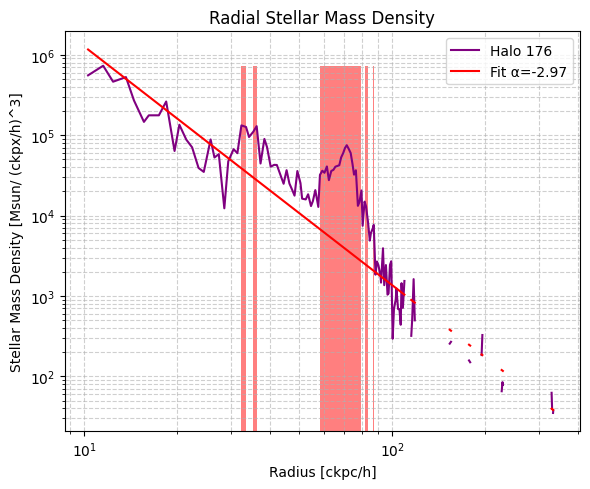

In [4]:
import matplotlib.pyplot as plt

index = 176
r_min = 10
dr=1
r_max=R200Crit[index]
single_profile = compute_mass_density_histogram(star_positions, star_masses, GroupPos[index],r_min, r_max, dr,factor_threshold=2)

# Define the fitted line
stellar_fit = 10**(single_profile["slope"] * np.log10(single_profile['median_r']) + single_profile['intercept'])
running_median = pd.Series(single_profile['weight_density']).rolling(5*dr, center=True).median().to_numpy()

corrected_profile = single_profile['median_r'] - running_median
# Plot
plt.figure(figsize=(6, 5))
plt.plot(single_profile['median_r'],single_profile['weight_density'], color='purple', label='Halo '+str(index))
#plt.plot(single_profile['median_r'],running_median, color='red', label='Halo '+str(index))

plt.plot(single_profile['median_r'],stellar_fit, color='red', label='Fit α='+str(single_profile['slope'].round(2)))
plt.fill_between(single_profile['median_r'], single_profile['weight_density'].min(), single_profile['weight_density'].max(), where=~single_profile['satellite_mask'], facecolor='red', alpha=0.5)
#plt.plot(single_profile['median_r'],single_profile['weight_density']-stellar_fit, color='purple', label='Halo '+str(index))

#plt.plot(single_profile['log_density'], stellar_fit, color='orange', linewidth=2, label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [ckpc/h]')
plt.ylabel('Stellar Mass Density [Msun/ (ckpx/h)^3]')
plt.title('Radial Stellar Mass Density')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [161]:
single_profile.keys()
import h5py
import os

def append_dict_to_hdf5(file_path, data_dict):
    mode = 'a' if os.path.exists(file_path) else 'w'
    with h5py.File(file_path, mode) as hf:
        # Create a new group with incremental name
        idx = len(hf)
        group = hf.create_group(f'entry_{idx:05d}')
        for key, val in data_dict.items():
            group.create_dataset(key, data=val)


In [7]:
dr = 1
r_min = 10
reslist = []
for i in range(GroupPos.shape[0]):
    if M200Crit[i]<10**13:
        continue
    else:
        r_max=R200Crit[i]
        center=GroupPos[i]
        result = compute_mass_density_histogram(star_positions, star_masses, center,r_min, r_max, dr,factor_threshold=2)
        result['HaloID'] = i
        reslist.append(result)
df = pd.DataFrame(reslist)

In [11]:
df.to_feather("dr1_rmin10_threshold2.feather")

In [12]:
read = pd.read_feather("dr1_rmin10_threshold2.feather")

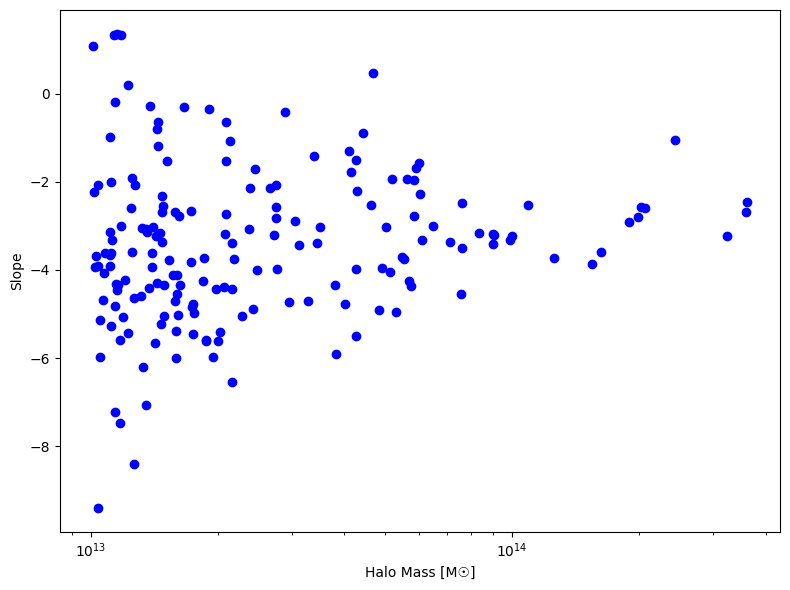

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Filter data for halo_mass >= 1e12 (since you're working in linear mass units)
plot_df = df.copy()
plot_df.halo_mass = 10**plot_df.halo_mass

# Fit a linear model in log-log space
# Define forward and inverse mapping using the log-log linear relationship
#def halo_to_stellar(hm):
#    return 10**10**(slope * np.log10(hm) + intercept)
#
#def stellar_to_halo(sm):
#    return 10**((np.log10(sm) - intercept) / slope)
#
## Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(plot_df['halo_mass'], plot_df['slope'], color='blue')
ax.set_xscale('log')
ax.set_xlabel('Halo Mass [M☉]')
ax.set_ylabel('Slope')

# Top axis in log scale using the power-law fit
#secax = ax.secondary_xaxis('top', functions=(halo_to_stellar, stellar_to_halo))
#secax.set_xscale('log')
#secax.set_xlabel('Stellar Mass [M☉] (fitted)')

plt.tight_layout()
plt.show()


In [37]:
print(halo_to_stellar(10e13))

12.09052071825754


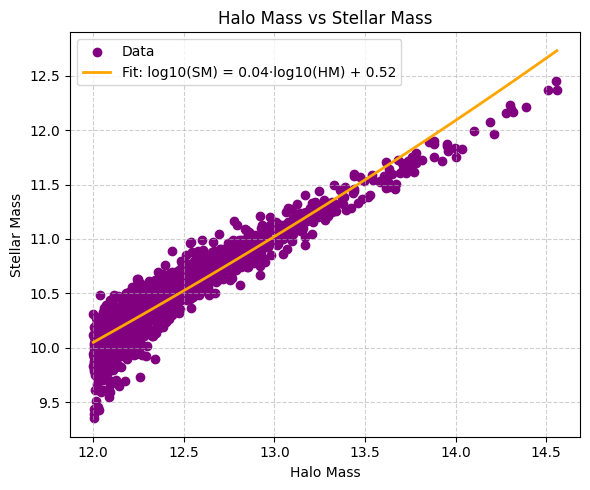

In [30]:
# Define the fitted line
halo_vals = np.linspace(df['halo_mass'].min(), df['halo_mass'].max(), 100)
stellar_fit = slope * halo_vals + intercept

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(df['halo_mass'], df['stellar_mass'], color='purple', label='Data')
plt.plot(halo_vals, 10**stellar_fit, color='orange', linewidth=2, label=f'Fit: log10(SM) = {slope:.2f}·log10(HM) + {intercept:.2f}')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Halo Mass')
plt.ylabel('Stellar Mass')
plt.title('Halo Mass vs Stellar Mass')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# function which returns binned quantities get_binned_x_vs_y(arratx,arrayy, bin_decision) -> 
# Median binning!